# Set Up

In [1]:
# Reviews CSV (updated)
%%capture
!wget https://www.dropbox.com/scl/fi/6u1yfcnnf4jqmhedx519u/reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6&st=ko3q9dnq&dl=0
!mv reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6 reviews.csv

# Reviews images related
!wget https://www.dropbox.com/scl/fi/2o3fmzj4jdsfujfhu0mns/reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt&st=3e3bpy5q&dl=0
!mv reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt reviews.zip
!unzip reviews.zip
# Metadata for each restaurant
!wget https://www.dropbox.com/scl/fi/cxckzuj81gsnlsvclqnza/metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru&st=sv6cnpzh&dl=0
!mv metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru metadata.json.gz

!wget https://www.dropbox.com/scl/fi/50pmwvytozpz0cl1p054f/tiny_LLaVa_images_descriptions.json.gz?rlkey=7vreygmtd16lohs3bx6yvmwdk&st=9568qz84&dl=0
!mv tiny_LLaVa_images_descriptions.json.gz?rlkey=7vreygmtd16lohs3bx6yvmwdk tiny_LLaVa_images_descriptions.json.gz

!wget https://www.dropbox.com/scl/fi/g8862obe2z29su61popjx/restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh&st=tqfdpqjv&dl=0
!mv restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh restaurants.csv

# Libraries

In [2]:
%%capture
!pip install --upgrade -q accelerate bitsandbytes
!pip install accelerate
!pip install pyreclab
!pip install cornac
!pip install pali-torch
!pip install einops torchvision

import pandas as pd
import numpy as np
import json
import gzip
import pyreclab
import random
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import os
# images
from keras.applications import vgg16, vgg19, ResNet50
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# text
import requests
import heapq
import math
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import time

# cornac
import cornac
from cornac.data import Reader, Dataset
import cornac.datasets
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality, ImageModality
from cornac.data.text import BaseTokenizer
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR, DMRL, AMR
import torch

# SBert
from sentence_transformers import SentenceTransformer

from concurrent.futures import ThreadPoolExecutor

In [73]:
import seaborn as sns

In [3]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch


In [4]:
from tqdm import tqdm

In [5]:
from collections import Counter

In [6]:
from itertools import combinations

# Data Preprocessing

In [7]:
df = pd.read_csv('reviews.csv')
print(f"Tamaño dataset: {df.shape}")

count_per_state = df['state'].value_counts()
for state, count in count_per_state.items():
    folder_size = len(os.listdir(f'reviews/{state}'))
    print(f"State: {state}, Count: {count}")
    print(f"Folder size {folder_size}")
    if folder_size >= count:
        print('- Se encuentran todas las imagenes => No hay conflictos\n')
    else:
        print('- Hay que eliminar imagenes => Conflicto\n')
        for row in df.itertuples():
            img_filename = row.img_filename
            path = f'{row.gmap_id}.png'
            state = row.state
            if path not in os.listdir(f'reviews/{state}'):
                print(row)

# Eliminamos datos nulos ...
df = df.dropna()


Tamaño dataset: (8334, 9)
State: Virginia, Count: 2881
Folder size 2948
- Se encuentran todas las imagenes => No hay conflictos

State: California, Count: 1775
Folder size 1775
- Se encuentran todas las imagenes => No hay conflictos

State: Texas, Count: 1134
Folder size 1134
- Se encuentran todas las imagenes => No hay conflictos

State: Hawaii, Count: 984
Folder size 984
- Se encuentran todas las imagenes => No hay conflictos

State: Florida, Count: 912
Folder size 912
- Se encuentran todas las imagenes => No hay conflictos

State: North_Dakota, Count: 648
Folder size 678
- Se encuentran todas las imagenes => No hay conflictos



In [8]:
X = df[['user_id', 'rest_id', 'rating']]

In [9]:
restaurants = pd.read_csv('restaurants.csv')


categories = restaurants['categories'].unique()
categ2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categ = {idx : categ for categ, idx in categ2idx.items()}


restaurants_lst = list(restaurants.iterrows())


X_categories = []
for row in X.itertuples():
    rest_id = row.rest_id
    categ = restaurants_lst[rest_id][1].categories
    idx_categ = categ2idx[categ]
    X_categories.append(idx_categ)

X['categ_id'] = X_categories

<ipython-input-9-0a147b4e1a57>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['categ_id'] = X_categories


In [10]:
restaurants.index

RangeIndex(start=0, stop=7044, step=1)

In [11]:
X.head()

,user_id,rest_id,rating,categ_id
0,114453580163034019886,3818,5,0
1,103598690263545033047,3819,5,262
2,115640749244801394506,3820,5,8
3,104421748665385525393,3822,5,0
4,108976745273958544598,3823,4,143


In [12]:
# Obtenemos el json de la metadata
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

metadata = list(parse('metadata.json.gz'))
metadata = metadata[0]

In [13]:
metadata.keys()

dict_keys(['California', 'Florida', 'Hawaii', 'North_Dakota', 'Texas', 'Virginia'])

In [14]:
new_metadata = []
for value in metadata.values():
    new_metadata.extend(value)
idx2metadata = {}
for data in new_metadata:
    gmap_id = data['gmap_id']
    del data['gmap_id']
    idx2metadata[gmap_id] = data

In [15]:
categories = restaurants['categories'].unique()
categories2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categories = {idx : categ for categ, idx in categories2idx.items()}
restaurants_dict = restaurants.to_dict('index')
restaurant_categories = {k : categories2idx[v['categories']] for k, v in restaurants_dict.items() }

# Utils


In [39]:
# reciprocal rank
def rr(recommendation, review):
    review = list(map(int, review))
    recommendation = list(map(int, recommendation))
    for i, rec in enumerate(recommendation):
        if rec in review:
            return 1 / (i + 1)
    return 0

def recall(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    recall = len(intersection) / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

def precision(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    precision_value = len(intersection) / len(recommended_items) if len(relevant_items) > 0 else 0
    return precision_value


def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def diversity(reclists):
    diversity_value = 0
    num_users = len(reclists.keys())

    for user, recommended_rests in reclists.items():

        unique_categories = set()
        for rest_id in recommended_rests:
            categ_id = restaurant_categories[int(rest_id)]
            categ_names = idx2categories[categ_id]

            if categ_names == "Restaurant":
                continue
            else:
                unique_categories.add(categ_id)

        diversity_value += len(unique_categories) / len(recommended_rests)

    return diversity_value / num_users



def novelty(reclists):
    ''' Funcion que retorna la novedad promedio de un metodo sobre un dataset'''
    # x_train deberia estar ya definido ...
    popularity = Counter(list(map(lambda x: x[1], x_train)))
    total_interactions = len(x_train)
    rest_popularity = {k: v / total_interactions for k, v in popularity.items()}

    novelty_value = 0
    num_users = len(reclists.keys())

    for user, reclist in reclists.items():
        novelty_score = 0

        for rest_id in reclist:
            if rest_id not in rest_popularity.keys():
                novelty_score += np.log(1 / total_interactions)
            else:
                novelty_score += np.log(1 / rest_popularity[int(rest_id)])

        novelty_value += novelty_score / len(reclist)

    return novelty_value / num_users

def get_relevant_items(user):
    user_reviews = test_user_items[user]
    user_reviews = list(
        map(lambda x: x[0],
        filter(lambda x: x[1] >= 3.5, user_reviews)
    ))
    return user_reviews

def MAP(model_reclist, n):
    mean_ap = 0.
    for u in test_user_items.keys():
        reclist = model_reclist[u]
        reclist = [int(x) for x in reclist]
        user_reviews = get_relevant_items(u)
        rel_vector = [np.isin(user_reviews, reclist, assume_unique=True).astype(int)]
        mean_ap += average_precision_at_k(rel_vector, n)
    mean_ap /= len(test_users)
    return mean_ap

def evaluate_model(model_reclist, n):
    mean_ap = 0.
    mean_ndcg = 0.
    mean_recall = 0.
    mean_precission = 0.
    mean_rr = 0.

    for u in test_user_items.keys():
        reclist = model_reclist[u]
        reclist = [int(x) for x in reclist]
        user_reviews = get_relevant_items(u)
        #user_reviews = test_users[u]


        rel_vector = [np.isin(user_reviews, reclist, assume_unique=True).astype(int)]


        mean_ap += average_precision_at_k(rel_vector, n)
        mean_ndcg += ndcg_at_k(rel_vector, n, len(user_reviews))

        mean_recall += recall(user_reviews, reclist)
        mean_precission += precision(user_reviews, reclist)
        mean_rr += rr(reclist, user_reviews)


    mean_ap /= len(test_users)
    mean_ndcg /= len(test_users)
    mean_recall /= len(test_users)
    mean_precission /= len(test_users)
    mean_rr /= len(test_users)

    novelty_value = novelty(model_reclist)
    diversity_value = diversity(model_reclist)

    print(f'MAP@{n}: {mean_ap}')
    print(f'nDCG@{n}: {mean_ndcg}')
    print(f'Recall@{n}: {mean_recall}')
    print(f'Precision@{n}: {mean_precission}')
    print(f'MRR@{n}: {mean_rr}')
    print(f'Novelty@{n}: {novelty_value}')
    print(f'Diversity@{n}: {diversity_value}')



In [17]:
def show_recommendations(user, reclist):
    rec_business_cols = {
        'name' : [],
        'description' : [],
        'categories': []

    }
    for row in restaurants.itertuples():
        index = row.Index
        if index not in reclist: continue
        rec_business_cols['name'].append(row.name)
        rec_business_cols['categories'].append(row.categories)
        rec_business_cols['description'].append(row.descriptions)

    reclist_df = pd.DataFrame(rec_business_cols)
    return reclist_df


# Models

## Multimodal Recssys (using LLaVa & all-MiniLM-L6-v2 )

In [ ]:
print(torch.cuda.is_available())

False


In [ ]:
# Importamos los modelos a usar
# LLaVa

model_id = "bczhou/tiny-llava-v1-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, device_map="cpu")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/61.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/661M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [18]:
# all-MiniLM-L6-v2
encoder = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Generate Imgs Descriptions

In [ ]:
MAX_NEW_TOKENS = 30 # Maxima cantidad de tokens generados por LLaVa
PREFIX = 'reviews' # Carpeta donde se encuentran las imagenes.
# Generaremos el resumen de cada imagen usando LLaVa y luego con SBert
# obtenemos el embedding del texto

def get_description(img):
    message = "What's in the picture? Give me a brief summary"
    prompt = f"USER: <image>{message}\nASSISTANT:"

    input = processor(prompt, images=img, padding=True, return_tensors="pt").to("cuda")
    output = model.generate(**input, max_new_tokens=MAX_NEW_TOKENS)
    generated_text = processor.batch_decode(output, skip_special_tokens=True)
    description = generated_text[0].split("ASSISTANT: ")[-1]
    return description

def generate_embeddings(df):
    def process_row(row):
        path = f'{PREFIX}/{row.img_filename}'
        img = Image.open(path)
        description = get_description(img) # Generamos la descripcion de la imagen con LLaVa
        embedding = model.encode(description) # Generamos el embedding con all-MiniLM-L6-v2
        # Asociamos cada fila del dataframe el embedding asociado a la imagen.
        return embedding

    embeddings = []
    with ThreadPoolExecutor(max_workers=50) as executor:  # Ajusta max_workers según tu hardware
        results = list(tqdm(executor.map(process_row, [row for _, row in df.iterrows()]), total=df.shape[0]))

    return results

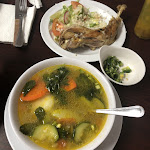

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
images = images = list(set(random.choices(os.listdir('reviews/California'), k=2)))
image = Image.open(f'reviews/California/{random.choice(images)}')
display(image)
get_description(image)

In [ ]:
images = [Image.open(f'reviews/{row.img_filename}').resize((128, 128)) for _, row in df.iterrows()]

In [ ]:
# Genera descripciones de imágenes en lotes y evita sobrecargar la GPU.
def batch_generate_descriptions(images):
    messages = ["What's in the picture? Give me a brief summary" for _ in images]
    prompts = [f"USER: <image>{message}\nASSISTANT:" for message in messages]

    inputs = processor(prompts, images=images, padding=True, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=MAX_NEW_TOKENS)
    generated_texts = processor.batch_decode(outputs, skip_special_tokens=True)

    descriptions = [text.split("ASSISTANT: ")[-1] for text in generated_texts]
    return descriptions


In [ ]:
def save_images_descriptions(df):
    img_description = {}
    batch_size = 16
    image_batch = []
    filenames = []

    for row in tqdm(df.itertuples(), total=len(df), desc="Processing rows"):
        img = Image.open(f'{PREFIX}/{row.img_filename}').resize((128, 128))
        image_batch.append(img)
        filenames.append(row.img_filename)

        # Procesamos el batch cuando alcanza el tamaño especificado ...
        if len(image_batch) == batch_size:
            descriptions = batch_generate_descriptions(image_batch)
            img_description.update({filenames[i]: descriptions[i] for i in range(len(filenames))})
            image_batch.clear()
            filenames.clear()
            torch.cuda.empty_cache()

    # procesamos las imgs restantes
    if image_batch:
        descriptions = batch_generate_descriptions(image_batch)
        img_description.update({filenames[i]: descriptions[i] for i in range(len(filenames))})
        torch.cuda.empty_cache()

    with gzip.open("images_descriptions.json.gz", 'wt', encoding='UTF-8') as zipfile:
        json.dump(img_description, zipfile)


In [ ]:
save_images_descriptions(df)

Processing rows: 100%|██████████| 8038/8038 [2:07:17<00:00,  1.05it/s]


## Download Imgs Descriptions

In [19]:
imgs_descriptions = list(parse("tiny_LLaVa_images_descriptions.json.gz"))[0]

In [20]:
imgs_embeddings = {}
# Generamos un embeddings de tamaño 384.
for key, value in tqdm(imgs_descriptions.items()):
    imgs_embeddings[key] = encoder.encode(value)


100%|██████████| 8038/8038 [03:07<00:00, 42.81it/s]


In [21]:
rev_embeddings = {}
for img_filename, emb in imgs_embeddings.items():
    gmap_id = img_filename.split("/")[-1].split(".")[0]
    rev_id = df[df['gmap_id'] == gmap_id].index[0]
    rev_embeddings[rev_id] = emb

In [22]:
rev_descriptions = {}
for img_filename, description in imgs_descriptions.items():
    gmap_id = img_filename.split("/")[-1].split(".")[0]
    rev_id = df[df['gmap_id'] == gmap_id].index[0]
    rev_descriptions[rev_id] = description


In [23]:
rev_id2info = X.to_dict('index')

In [24]:
user_reviews = {}
for r in X.itertuples():
    if not user_reviews.get(r.user_id):
        user_reviews[r.user_id] = []
    # (review ID, restaurant ID, review's rating, restaurant categories ID)
    user_reviews[r.user_id].append((r.Index, r.rest_id, r.rating, r.categ_id))

In [25]:
allreviews = np.array(list({ u : len(r) for u, r in user_reviews.items()}.values()))

In [26]:
print(len(user_reviews.keys()))

7254


In [27]:
print(allreviews.min())
print(allreviews.mean())
print(allreviews.max())

1
1.1080783016266886
10


In [28]:
count_reviews = Counter(allreviews)
for k, v in sorted(count_reviews.items(), key=lambda x: x[0]):
    print(f'{k:<2} {v:>5}')

1   6700
2    423
3     79
4     27
5     13
6      7
7      3
9      1
10     1


Por cada review de un usuario, creamos el set de train y el de test.
En el caso que un usuario tiene mas de una review, dejamos el 20% de las reviews para test y el resto para train (esto permite que el usuario tenga reviews tanto en testing como en training).
En el otro caso, si el usuario no tiene mas de 1 review, entonces lo dejamos para "entrenar el modelo", ya que no podriamos saber mas info.

In [29]:
train_set, test_set = [], []

for user, reviews in user_reviews.items():
    if len(reviews) <= 1:
        train_set.append(reviews)
    else:
        if 1 < len(reviews) <= 3:           # 2 o 3 reviews
            train_data, test_data = train_test_split(reviews, test_size=0.5, random_state=42)
        elif 3 < len(reviews) <= 5:         # 4 o 5 reviews
            train_data, test_data = train_test_split(reviews, test_size=0.6, random_state=42)
        else:                               # 6 o + reviews
            train_data, test_data = train_test_split(reviews, test_size=0.8, random_state=42)
        train_set.append(train_data)
        test_set.append(test_data)

In [30]:
x_train, x_test = [], []
for d in train_set:
    x_train.extend(d)
for d in test_set:
    x_test.extend(d)

> (review ID, restaurant ID, review's rating, restaurant categories ID)

In [31]:
print('Tamaño de Xtrain: ', len(x_train))
print('Tamaño de Xtest: ', len(x_test))

Tamaño de Xtrain:  7268
Tamaño de Xtest:  770


In [32]:
x_train[0]

(0, 3818, 5, 0)

In [33]:
train_embeddings = list(map(lambda x: rev_embeddings[x[0]], x_train))

In [34]:
test_users = {}
for x in x_test:
    rev_id = x[0]
    user_id = rev_id2info[rev_id]['user_id']
    if not test_users.get(user_id):
        test_users[user_id] = []
    test_users[user_id].append(rev_id)


In [35]:
train_users = {}
for x in x_train:
    rev_id = x[0]
    user_id = rev_id2info[rev_id]['user_id']

    if not train_users.get(user_id):
        train_users[user_id] = []

    train_users[user_id].append(rev_id)

## Training functions

In [36]:
def get_test_embedding(user_id, reviews, mode='knn'):
    # @Input: Obtenemos el id de un usuario y los ids de sus reviews realizadas
    # Si el usuario solo hizo una review en testing, entonces retornamos el embedding de solo esa review.
    if len(reviews) <= 1:
        rev_id = reviews[0]

        return rev_embeddings[rev_id]

    # Si hizo al menos 2 reviews, usamos similitud del coseno para ver que review de testing
    # es la que presenta mayor similitud con las reviews del training.
    # Escogemos la review con la similitud mas alta.

    user_train_revs = train_users[user_id]  # Reviews realizadas por el usuario (train)
    user_test_revs = reviews                # Reviews de testing del usuario (por predecir)

    user_train_embeddings = list(map(lambda rev_id: rev_embeddings[rev_id], user_train_revs))

     # En el caso que sea mean, retornamos el promedio de las reviews de train
    if mode == 'mean':
        user_test_embeddings = list(map(lambda rev_id: rev_embeddings[rev_id], user_test_revs))
        return np.mean(user_test_embeddings, axis=0)


    max_sim_test_idx = -1                   # Indice de la review de testing que tiene maxima similitud
    max_sim_value = -1                      # Valor de similitud maximo alcanzado

    for test_idx, rev_id in enumerate(user_test_revs):
        user_test_embedding = rev_embeddings[rev_id]

        similarities = encoder.similarity(user_test_embedding, user_train_embeddings).cpu().numpy()[0]
        max_curr_sim = similarities.mean()

        if max_sim_value < max_curr_sim:
            max_sim_value = max_curr_sim    # actualizamos el valor mas alto de similitud
            max_sim_test_idx = test_idx     # actualizamos el indice del test embedding con mas similitud


    # Escogemos el embedding con maxima similitud.

    best_id = user_test_revs[max_sim_test_idx]
    best_test_embedding = rev_embeddings[best_id]

    return best_test_embedding

In [47]:
# Retorna la lista de recomendaciones
def llava_train(train_users, test_users, mode='knn', k_values=[10, 20]):
    llava_reclists = {}

    for user_id, reviews in tqdm(test_users.items(), desc="Procesando ... "):
        llava_reclists[user_id] = { k : [] for k in k_values }
        test_embedding = get_test_embedding(user_id, reviews, mode)

        # Realizamos "KNN" para buscar los embeddings del training mas cercanos con
        # respecto al embedding de testing

        similarities = encoder.similarity(test_embedding, train_embeddings).cpu().numpy()[0]

        # Ordenamos de mayor a menor.

        sorted_idxs = similarities.argsort()[::-1]

        # Aca realizamos el KNN-k, con k en {10, 20}.
        for k in k_values:
            recommended_restaurants_k = []

            for idx in sorted_idxs:
                rest_id = x_train[idx][1] # Rest ID

                # Como son reviews, pueden ser del mismo restaurant -> Aseguramos no duplicados
                if rest_id not in recommended_restaurants_k:
                    recommended_restaurants_k.append(rest_id)
                    llava_reclists[user_id][k].append(rest_id)

                if len(recommended_restaurants_k) == k:
                    break
    # Guardamos la lista de recomendaciones
    with gzip.open("LLaVa_users_reclists.json.gz", 'wt', encoding='UTF-8') as zipfile:
        json.dump(llava_reclists, zipfile)

    return llava_reclists


In [48]:
test_user_items = {} # Usuario de testing y restaurantes evaluados ...
for user, reviews in test_users.items():
    test_user_items[user] = [(rev_id2info[r]['rest_id'], rev_id2info[r]['rating']) for r in reviews]

# Sensitivity analysis

In [49]:
k_values = [5, 10, 20, 30, 50]
llava_most_sim_reclist = llava_train(train_users, test_users, mode='knn', k_values=k_values)

Procesando ... : 100%|██████████| 554/554 [02:43<00:00,  3.38it/s]


In [51]:
llava_mean_reclist = llava_train(train_users, test_users, mode='mean', k_values=k_values)

Procesando ... : 100%|██████████| 554/554 [02:43<00:00,  3.39it/s]


Guardamos cada lista en un diccionario global de la forma:

    5 : {
        user1 : [a,b,d,c,t],
        user2 : [d,f,g,a,t]
    },
    10: {
        user1 : [a,b,d,c,t, ...],
        user2 : [d,f,g,a,t, ...]
    },
    ...


In [88]:
global_llava_most_sim_reclists_k = { k : None for k in k_values }
global_llava_mean_reclists_k = { k : None for k in k_values }

for k in k_values:
    # Vamos por usuario y guardamos segun valor de lista
    llava_most_sim_reclist_k, llava_mean_reclist_k = {}, {}

    # LLaVA Most similar
    for user_id, reclists in llava_most_sim_reclist.items():
        llava_most_sim_reclist_k[user_id] = reclists[k]
    global_llava_most_sim_reclists_k[k] = llava_most_sim_reclist_k

    # LLaVA Mean
    for user_id, reclists in llava_mean_reclist.items():
        llava_mean_reclist_k[user_id] = reclists[k]
    global_llava_mean_reclists_k[k] = llava_mean_reclist_k


In [89]:
map_values = []
for k in k_values:
    map_llava_most_sim = MAP(global_llava_most_sim_reclists_k[k], k)
    map_llava_mean = MAP(global_llava_mean_reclists_k[k], k)
    map_values.append((map_llava_most_sim, map_llava_mean))

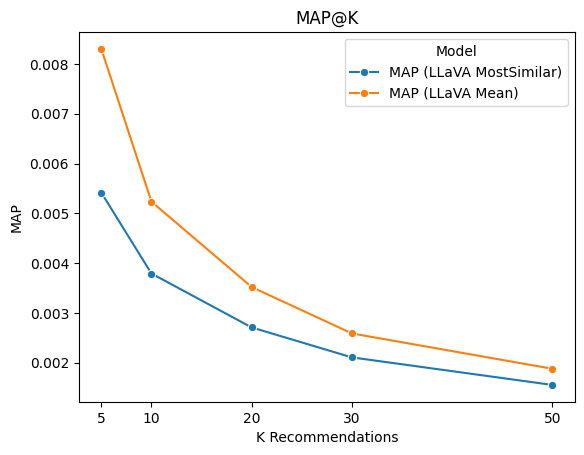

In [106]:
models = ['LLaVA (MostSimilar)', 'LLaVA (Mean)']

llava_mostsim_map_values, llava_mean_map_values = list(zip(*map_values))
df_map_plot = pd.DataFrame({
    'K Recommendations': k_values,
    'MAP (LLaVA MostSimilar)' : llava_mostsim_map_values,
    'MAP (LLaVA Mean)' : llava_mean_map_values
})

df_map_plot = df_map_plot.melt(
    id_vars='K Recommendations',
    var_name='Model',
    value_name='MAP'
)

sns.lineplot(data=df_map_plot, x='K Recommendations', y='MAP', hue='Model', marker='o')
plt.title("MAP@K")
plt.xticks(k_values)
plt.show()

In [96]:
novelty_values = []
diversity_values = []

for k in k_values:
    novelty_llava_most_sim = novelty(global_llava_most_sim_reclists_k[k])
    diversity_llava_most_sim = diversity(global_llava_most_sim_reclists_k[k])

    novelty_llava_mean = novelty(global_llava_mean_reclists_k[k])
    diversity_llava_mean = diversity(global_llava_mean_reclists_k[k])

    novelty_values.append((novelty_llava_most_sim, novelty_llava_mean))
    diversity_values.append((diversity_llava_most_sim, diversity_llava_mean))

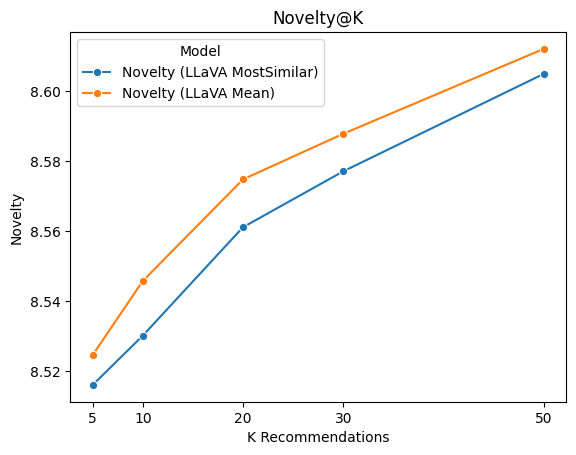

In [105]:
llava_mostsim_novelty_values, llava_mean_novelty_values = list(zip(*novelty_values))

df_map_plot = pd.DataFrame({
    'K Recommendations': k_values,
    'Novelty (LLaVA MostSimilar)' : llava_mostsim_novelty_values,
    'Novelty (LLaVA Mean)' : llava_mean_novelty_values
})

df_map_plot = df_map_plot.melt(
    id_vars='K Recommendations',
    var_name='Model',
    value_name='Novelty'
)

sns.lineplot(data=df_map_plot, x='K Recommendations', y='Novelty', hue='Model', marker='o')
plt.title("Novelty@K")
plt.xticks(k_values)
plt.show()

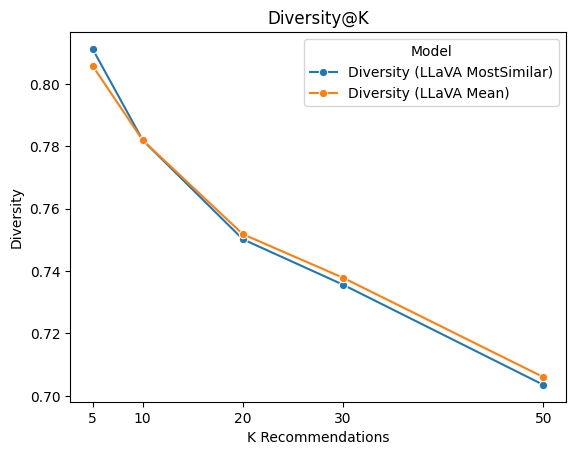

In [104]:
llava_mostsim_diversity_values, llava_mean_diversity_values = list(zip(*diversity_values))

df_map_plot = pd.DataFrame({
    'K Recommendations': k_values,
    'Diversity (LLaVA MostSimilar)' : llava_mostsim_diversity_values,
    'Diversity (LLaVA Mean)' : llava_mean_diversity_values
})

df_map_plot = df_map_plot.melt(
    id_vars='K Recommendations',
    var_name='Model',
    value_name='Diversity'
)

sns.lineplot(data=df_map_plot, x='K Recommendations', y='Diversity', hue='Model', marker='o')
plt.title("Diversity@K")
plt.xticks(k_values)
plt.show()

# Results

## LLaVA - Most Similar

In [ ]:
print('LLaVA (Case 1: Most Similar)')
llava_most_sim_reclist = llava_train(train_users, test_users, mode='knn')

LLaVA (Case 1: Most Similar)


Procesando ... : 100%|██████████| 554/554 [02:48<00:00,  3.29it/s]


### Metrics

In [ ]:
llava_most_sim_reclist10, llava_most_sim_reclist20 = {}, {}

for user_id, reclists in llava_most_sim_reclist.items():
    llava_most_sim_reclist10[user_id] = reclists[10]
    llava_most_sim_reclist20[user_id] = reclists[20]

In [ ]:
evaluate_model(llava_most_sim_reclist10, n=10)

MAP@10: 0.0037906137184115533
nDCG@10: 0.03650955665258289
Recall@10: 0.036101083032490974
Precision@10: 0.0037906137184115533
MRR@10: 0.02019655034095467
Novelty@10: 8.530155799314224
Diversity@10: 0.7819494584837541


In [ ]:
evaluate_model(llava_most_sim_reclist20, n=20)

MAP@20: 0.0027075812274368243
nDCG@20: 0.05025169959981296
Recall@20: 0.048736462093862815
Precision@20: 0.002617328519855597
MRR@20: 0.021150430545723433
Novelty@20: 8.561162787036437
Diversity@20: 0.7501805054151622


### Examples

Recomendaciones realizadas con LLava Most Similar

In [ ]:
random_user = '100012107238749468669'
show_recommendations(
    user=random_user,
    reclist=llava_most_sim_reclist10['100012107238749468669']
)

,name,description,categories
0,Daedo Sikdang,NaN,Restaurant
1,WingMan,NaN,Chicken wings restaurant;Restaurant;Fast food ...
2,D. Tequila Lounge & Restaurant,NaN,Event venue;Restaurant;Sports bar
3,Sgt Peppers Dueling Pianos,Lively nightspot & bar featuring dueling-piano...,Piano bar;Brunch restaurant;Live music venue;B...
4,O'Hana Karaoke & Grill,NaN,Korean restaurant
5,Gertrude's Jazz Bar,Nightly music from jazz & blues to rock in a m...,Night club;Live music venue;Restaurant;Bar;Tap...
6,Carr Brothers Gathering Place,NaN,American restaurant;Bar & grill
7,Hungry Brother BBQ,NaN,Barbecue restaurant
8,Blue Mountain Barrel House & Smokin' Barrel Re...,NaN,Brewery;Restaurant
9,Ruthie's All-Day,NaN,Takeout Restaurant;Restaurant


In [ ]:
show_recommendations(
    user=random_user,
    reclist=llava_most_sim_reclist20['100012107238749468669']
)

,name,description,categories
0,Daedo Sikdang,NaN,Restaurant
1,WingMan,NaN,Chicken wings restaurant;Restaurant;Fast food ...
2,Katzya Chicken & Donkatsu,NaN,Restaurant
3,TORO,NaN,Restaurant
4,Bekker's Catering,NaN,Caterer;Takeout Restaurant;Event planner
5,D. Tequila Lounge & Restaurant,NaN,Event venue;Restaurant;Sports bar
6,Sgt Peppers Dueling Pianos,Lively nightspot & bar featuring dueling-piano...,Piano bar;Brunch restaurant;Live music venue;B...
7,Il Sogno,NaN,Restaurant
8,Dargenzio Winery,Charming locale with a warm atmosphere for tas...,Wine bar;Bar restaurant furniture store;Wine s...
9,Ocean Beach Cafe,NaN,Breakfast restaurant;Coffee shop;Sandwich shop...


### Description Analysis

In [ ]:
restaurants_descriptions = {}
for rev_id, description in rev_descriptions.items():

    rest_id = rev_id2info[rev_id]['rest_id']
    rest_name = restaurants_dict[rest_id]['name']

    if not restaurants_descriptions.get(rest_name):
        restaurants_descriptions[rest_name] = []

    restaurants_descriptions[rest_name].append(description)

In [ ]:
def print_descriptions(reclist):

    for rest_id in reclist:
        rest_name = restaurants_dict[rest_id]['name']
        print('\n', rest_name.upper(), '\n')
        for desc in restaurants_descriptions[rest_name]:
            sentences = desc.split('.')
            for sentence in sentences:
                if len(sentence) > 100:
                    sentence = sentence.split(',')
                    for part in sentence:
                        print(part)
                else:
                    print(sentence)


        print('\n' * 1)
        print('-' * 100)

In [ ]:
print_descriptions(llava_most_sim_reclist10[random_user])


 GERTRUDE'S JAZZ BAR 

The image depicts a lively scene of a group of people gathered in a room
 likely a bar or concert venue
 They are standing and sitting, with some of them holding guitars
 There are at least four guitars visible in the scene
 indicating that they might be playing or preparing to play music


The room is filled with people, with some standing closer to the front and others further back
 They are engaged in conversation and enjoying the atmosphere, creating a sense of camaraderie
 The room appears to be well-lit, with a bright light illuminating the space



----------------------------------------------------------------------------------------------------

 CARR BROTHERS GATHERING PLACE 

The image depicts a lively scene of a group of people gathered in a bar or restaurant
 There are several people sitting and standing around, enjoying each other's company
 Some of the individuals are sitting on chairs, while others are standing


In the background
 there are two

Podemos notar que gran parte de las recomendaciones tienen en comun sobre restaurantes con un gran ambiente musical, con gente y buen ambiente. Si bien no es del mismo "tipo" (como comida mexicana, tailandesa, etc..), la descripcion de la imagen da implicitamente el gusto de la persona.

## LLaVA Mean

In [ ]:
print('LLaVA (Case 1: Mean)')
llava_mean_reclist = llava_train(train_users, test_users, mode='mean')

LLaVA (Case 1: Mean)


Procesando ... : 100%|██████████| 554/554 [02:50<00:00,  3.25it/s]


### Metrics

In [ ]:
llava_mean_reclist10, llava_mean_reclist20 = {}, {}

for user_id, reclists in llava_mean_reclist.items():
    llava_mean_reclist10[user_id] = reclists[10]
    llava_mean_reclist20[user_id] = reclists[20]

In [ ]:
evaluate_model(llava_mean_reclist10, n=10)

MAP@10: 0.005234657039711194
nDCG@10: 0.04483653714493931
Recall@10: 0.04422382671480144
Precision@10: 0.005054151624548739
MRR@10: 0.02937224227837946
Novelty@10: 8.54579321789936
Diversity@10: 0.7819494584837544


In [ ]:
evaluate_model(llava_mean_reclist20, n=20)

MAP@20: 0.003519855595667872
nDCG@20: 0.059834227224937746
Recall@20: 0.05836341756919375
Precision@20: 0.0034296028880866445
MRR@20: 0.030456970140009892
Novelty@20: 8.574839579615794
Diversity@20: 0.7518050541516244


### Examples

Recomendaciones realizadas con LLaVA Mean

In [ ]:
show_recommendations(
    user=random_user,
    reclist=llava_mean_reclist10['100012107238749468669']
)

,name,description,categories
0,Daedo Sikdang,NaN,Restaurant
1,WingMan,NaN,Chicken wings restaurant;Restaurant;Fast food ...
2,D. Tequila Lounge & Restaurant,NaN,Event venue;Restaurant;Sports bar
3,Sgt Peppers Dueling Pianos,Lively nightspot & bar featuring dueling-piano...,Piano bar;Brunch restaurant;Live music venue;B...
4,O'Hana Karaoke & Grill,NaN,Korean restaurant
5,Gertrude's Jazz Bar,Nightly music from jazz & blues to rock in a m...,Night club;Live music venue;Restaurant;Bar;Tap...
6,Carr Brothers Gathering Place,NaN,American restaurant;Bar & grill
7,Hungry Brother BBQ,NaN,Barbecue restaurant
8,Blue Mountain Barrel House & Smokin' Barrel Re...,NaN,Brewery;Restaurant
9,Ruthie's All-Day,NaN,Takeout Restaurant;Restaurant


In [ ]:
show_recommendations(
    user=random_user,
    reclist=llava_mean_reclist20['100012107238749468669']
)

,name,description,categories
0,Daedo Sikdang,NaN,Restaurant
1,WingMan,NaN,Chicken wings restaurant;Restaurant;Fast food ...
2,Katzya Chicken & Donkatsu,NaN,Restaurant
3,TORO,NaN,Restaurant
4,Bekker's Catering,NaN,Caterer;Takeout Restaurant;Event planner
5,D. Tequila Lounge & Restaurant,NaN,Event venue;Restaurant;Sports bar
6,Sgt Peppers Dueling Pianos,Lively nightspot & bar featuring dueling-piano...,Piano bar;Brunch restaurant;Live music venue;B...
7,Il Sogno,NaN,Restaurant
8,Dargenzio Winery,Charming locale with a warm atmosphere for tas...,Wine bar;Bar restaurant furniture store;Wine s...
9,Ocean Beach Cafe,NaN,Breakfast restaurant;Coffee shop;Sandwich shop...


### Description Analysis

In [ ]:
print_descriptions(llava_mean_reclist10[random_user])


 GERTRUDE'S JAZZ BAR 

The image depicts a lively scene of a group of people gathered in a room
 likely a bar or concert venue
 They are standing and sitting, with some of them holding guitars
 There are at least four guitars visible in the scene
 indicating that they might be playing or preparing to play music


The room is filled with people, with some standing closer to the front and others further back
 They are engaged in conversation and enjoying the atmosphere, creating a sense of camaraderie
 The room appears to be well-lit, with a bright light illuminating the space



----------------------------------------------------------------------------------------------------

 CARR BROTHERS GATHERING PLACE 

The image depicts a lively scene of a group of people gathered in a bar or restaurant
 There are several people sitting and standing around, enjoying each other's company
 Some of the individuals are sitting on chairs, while others are standing


In the background
 there are two